In [2]:
from typing import Tuple
import numpy as np

def generate_grid_mesh(height: int, width: int, flatten_arrays: bool = True) -> Tuple[np.ndarray, np.ndarray]:
  # define grid offsets
  grid_offsets = np.zeros((height + 1, width + 1, 2), dtype=np.int32)
  grid_offsets[:, :, 0] = np.arange(height + 1)[:, None]
  grid_offsets[:, :, 1] = np.arange(width + 1)[None, :]
  
  unique_grid_unit_points = np.array([[0.0, 0.0], [0.5, 0.0], [0.0, 0.5], [0.5, 0.5]])

  # h+1 x w+1 x 4 x 2
  grid_points = unique_grid_unit_points[None, None, :] + np.flip(grid_offsets, -1)[:, :, None, :]

  grid_indices = np.zeros((height + 1, width + 1, 4, 3), dtype=np.int32)
  grid_indices[:, :, :, 0] = np.arange(4)[None, None, :]
  grid_indices[:, :, :, 1:] = grid_offsets[:, :, None, :]

  # h x w x 4 x 3
  a = grid_indices[:-1, :-1]
  b = grid_indices[:-1, 1:]
  c = grid_indices[1:, :-1]
  d = grid_indices[1:, 1:]
  gridded_triangles = [
    (a[:, :, 0], a[:, :, 3], a[:, :, 1]),
    (a[:, :, 0], a[:, :, 2], a[:, :, 3]),
    (a[:, :, 1], a[:, :, 3], b[:, :, 0]),
    (a[:, :, 3], b[:, :, 2], b[:, :, 0]),
    (a[:, :, 2], c[:, :, 0], a[:, :, 3]),
    (a[:, :, 3], c[:, :, 0], c[:, :, 1]),
    (a[:, :, 3], c[:, :, 1], d[:, :, 0]),
    (a[:, :, 3], d[:, :, 0], b[:, :, 2])
  ]
  triangles = []
  for pointset in gridded_triangles:
    # h x w x 3 x 3 (third axis is the grid coordinate)
    pointset = np.stack(pointset, axis=-1)
    # h x w x 3 (grid coordinate converted to flat index)
    pointset = (
      pointset[:, :, 2, :] * 4
      + pointset[:, :, 1, :] * (width + 1) * 4
      + pointset[:, :, 0, :]
    )
    triangles.append(pointset)
  triangles = np.stack(triangles)

  points = np.concatenate((grid_points, np.zeros((height + 1, width + 1, 4, 1))), axis=-1)
  if flatten_arrays:
    points = points.reshape(-1, 3)
    # (8 x h x w) x 3 (list of triangles - 8 per grid face)
    triangles = np.concatenate(triangles).reshape(-1, 3)
  return points, triangles

# points, triangles = generate_grid_mesh(4, 2)
# save_stl(points, triangles, 'output.stl')

In [ ]:
from stl import mesh

def save_stl(vertices, faces, filename):
    """
    Save vertex and face data as an STL file.

    @param vertices: n x 3 array of 3D points.
    @param faces: m x 3 array of vertex indices specifying triangles.
    """
    # Create the mesh
    triangle_mesh = mesh.Mesh(np.zeros(faces.shape[0], dtype=mesh.Mesh.dtype))
    
    # Fill in the mesh vertices for each triangle
    for i, face in enumerate(faces):
        for j in range(3):
            triangle_mesh.vectors[i][j] = vertices[face[j]]
    
    # Save to file
    triangle_mesh.save(filename)

In [3]:
import os
os.chdir('C:/Users/clack/Projects/nwm')

from pathlib import Path
import numpy as np
from PIL import Image
from experiment.nav2d import Topo

state = Topo.random()
terrain = state.terrain[64:256-64, 64:256-64]

def save_terrain_as_obj(terrain: np.ndarray, origin: np.ndarray, scale: float, save_dir: str):
  # h+1 x w+1 x 4 x 3
  height = terrain.shape[0] * 2 - 1
  width = terrain.shape[1] * 2 - 1
  points, triangles = generate_grid_mesh(height, width, flatten_arrays=False)
  grid_offsets = np.zeros((height + 1, width + 1, 2), dtype=np.int32)
  grid_offsets[:, :, 0] = np.arange(height + 1)[:, None]
  grid_offsets[:, :, 1] = np.arange(width + 1)[None, :]

  even_x = grid_offsets[:, :, 0] % 2 == 0
  even_y = grid_offsets[:, :, 1] % 2 == 0
  unit_mask = even_x & even_y
  y_sandwich_mask = ~even_x & even_y & (grid_offsets[:, :, 0] < height)
  x_sandwich_mask = even_x & ~even_y & (grid_offsets[:, :, 1] < width)
  corner_mask = ~even_x & ~even_y & (grid_offsets[:, :, 0] < height) & (grid_offsets[:, :, 1] < width)

  terrain = np.flip(terrain, axis=1)
  modulated_terrain_height = np.zeros_like(terrain)
  modulated_terrain_height[terrain < state.wall_height] = terrain[terrain < state.wall_height] * 10
  modulated_terrain_height[terrain >= state.wall_height] = terrain[terrain >= state.wall_height] * 20 + 4

  # set every other 3x3 grid region to the corresponding terrain height
  points[unit_mask, :, 2] = modulated_terrain_height[:, :, None].repeat(4, -1).reshape(-1, 4)
  points[y_sandwich_mask, 0, 2] = modulated_terrain_height[:-1, :].reshape(-1)
  points[y_sandwich_mask, 1, 2] = modulated_terrain_height[:-1, :].reshape(-1)
  points[x_sandwich_mask, 0, 2] = modulated_terrain_height[:, :-1].reshape(-1)
  points[x_sandwich_mask, 2, 2] = modulated_terrain_height[:, :-1].reshape(-1)
  points[corner_mask, 0, 2] = modulated_terrain_height[:-1, :-1].reshape(-1)

  # set interstitial points to interpolated heights
  y_interpolated_height = (modulated_terrain_height[:-1] + modulated_terrain_height[1:]) / 2
  points[y_sandwich_mask, 2, 2] = y_interpolated_height.reshape(-1)
  points[y_sandwich_mask, 3, 2] = y_interpolated_height.reshape(-1)
  points[corner_mask, 2, 2] = y_interpolated_height[:, :-1].reshape(-1)
  x_interpolated_height = (modulated_terrain_height[:, :-1] + modulated_terrain_height[:, 1:]) / 2
  points[x_sandwich_mask, 1, 2] = x_interpolated_height.reshape(-1)
  points[x_sandwich_mask, 3, 2] = x_interpolated_height.reshape(-1)
  points[corner_mask, 1, 2] = x_interpolated_height[:-1, :].reshape(-1)
  corner_interpolated_height = (x_interpolated_height[:-1] + x_interpolated_height[1:] + y_interpolated_height[:, :-1] + y_interpolated_height[:, 1:]) / 4
  points[corner_mask, 3, 2] = corner_interpolated_height.reshape(-1)


  colors = np.array([
    [0.6, 0.5, 0.4],  # dirt paths
    [0.25, 0.3, 0.2]  # green mountaintops
  ])
  texture = colors[(terrain.transpose(0, 1) >= state.wall_height).astype(np.int32)]
  texture_coordinates = points[:, :, :, :2].copy().reshape(-1, 2)
  texture_coordinates[:, 0] = texture_coordinates[:, 0] / (height + 1)
  texture_coordinates[:, 1] = 1 - texture_coordinates[:, 1] / (width + 1)
  # set offset
  points *= scale
  points += origin - 0.5

  # save_stl(points.reshape(-1, 3), triangles.reshape(-1, 3), 'output.stl')
  create_textured_mesh(points.reshape(-1, 3), triangles.reshape(-1, 3), texture_coordinates, texture, str(Path(save_dir) / 'terrain.obj'), str(Path(save_dir) / 'terrain.png'))

def create_textured_mesh(vertices, faces, texture_coords, texture_image,
                         obj_filename, texture_filename):
    """
    Create a mesh with arbitrary UV texture mapping.
    
    Parameters:
    -----------
    vertices : np.ndarray, shape (n, 3)
        Vertex positions
    faces : np.ndarray, shape (m, 3)
        Triangle indices into vertices
    texture_coords : np.ndarray, shape (n, 2)
        UV coordinates for each vertex, range [0, 1]
        (u, v) where u is horizontal, v is vertical
    texture_image : np.ndarray, shape (h, w, 3)
        RGB texture image, values in range [0, 255] or [0, 1]
    obj_filename : str
        Output OBJ filename
    texture_filename : str
        Output PNG texture filename
    """
    
    # Ensure texture is in [0, 255] range
    if texture_image.max() <= 1.0:
        texture_image = (texture_image * 255).astype(np.uint8)
    else:
        texture_image = texture_image.astype(np.uint8)
    
    # Save texture image
    Image.fromarray(texture_image).save(texture_filename)
    
    # Write OBJ file
    with open(obj_filename, 'w') as f:
        f.write("# OBJ file with custom UV texture mapping\n")
        f.write(f"mtllib {obj_filename.replace('.obj', '.mtl')}\n\n")
        
        # Write vertices
        for vert in vertices:
            f.write(f"v {vert[0]} {vert[1]} {vert[2]}\n")
        
        f.write("\n")
        
        # Write UV coordinates
        for uv in texture_coords:
            f.write(f"vt {uv[0]} {uv[1]}\n")
        
        f.write("\n")
        f.write("usemtl material_0\n")
        
        # Write faces (OBJ uses 1-based indexing)
        for face in faces:
            # Each vertex index also refers to its UV coordinate (same index)
            f.write(f"f {face[0]+1}/{face[0]+1} {face[2]+1}/{face[2]+1} {face[1]+1}/{face[1]+1}\n")
            # f.write(f"f {face[0]+1}/{face[0]+1} {face[1]+1}/{face[1]+1} {face[2]+1}/{face[2]+1}\n")
    
    # Write MTL file
    mtl_filename = obj_filename.replace('.obj', '.mtl')
    with open(mtl_filename, 'w') as f:
        f.write("# MTL file\n")
        f.write("newmtl material_0\n")
        f.write("Ka 1.0 1.0 1.0\n")
        f.write("Kd 1.0 1.0 1.0\n")
        f.write("Ks 0.0 0.0 0.0\n")
        f.write(f"map_Kd {texture_filename}\n")
    
    print(f"Created {obj_filename}, {mtl_filename}, and {texture_filename}")
    print(f"Vertices: {len(vertices)}")
    print(f"Faces: {len(faces)}")
    print(f"Texture size: {texture_image.shape[0]}x{texture_image.shape[1]}")

In [39]:
import os
import time
os.chdir('C:/Users/clack/Projects/nwm')
import mujoco
from experiment.nav2d import Topo

class MuJoCoTopo:
  def __init__(self, state: Topo, render_distance: int = 32, topo_camera_height: int = 100, camera_size: int = 64) -> None:
    self.state = state
    self.render_distance = render_distance
    self.render_offset = self.state.terrain_size // 2
    
    rendered_region = self.state.terrain[
      self.render_offset - render_distance:self.render_offset + render_distance,
      self.render_offset - render_distance:self.render_offset + render_distance
    ]
    save_terrain_as_obj(rendered_region, -np.array([render_distance, render_distance, 0]), 0.5, 'experiment/')
    self.model: mujoco.MjModel = mujoco.MjModel.from_xml_path('experiment/terrain.xml')
    self.data: mujoco.MjData = mujoco.MjData(self.model)

    self.goat_body_id = mujoco.mj_name2id(self.model, mujoco.mjtObj.mjOBJ_BODY, 'goat')
    self.goat_mocap_id = self.model.body_mocapid[self.goat_body_id]
    self.egocentric_goat_cam_id = mujoco.mj_name2id(self.model, mujoco.mjtObj.mjOBJ_CAMERA, 'egocentric_goat_cam')
    self.topo_goat_cam_id = mujoco.mj_name2id(self.model, mujoco.mjtObj.mjOBJ_CAMERA, 'topo_goat_cam')
    self.renderer = mujoco.Renderer(self.model, height=camera_size, width=camera_size)
    # self.egocentric_goat_cam_id = mujoco.Renderer(self.model, height=camera_size, width=camera_size)
    
    # initialize mocap position
    self.previous_state_position = self.state.position.copy()
    self.goat_position = self.state.position.copy()
    self.goat_velocity = np.zeros(2)
    self.goat_angle = 0
    self.update_goat_position()
    self.model.cam_pos[self.topo_goat_cam_id, 2] = topo_camera_height
    mujoco.mj_forward(self.model, self.data)

  def update_goat_position(self):
    translated_pos = self.goat_position.copy()
    translated_pos[0] = -self.goat_position[0] + self.render_offset
    translated_pos[1] = self.goat_position[1] - self.render_offset
    
    self.data.mocap_pos[self.goat_mocap_id, :2] = translated_pos
    self.model.cam_pos[self.topo_goat_cam_id, :2] = translated_pos

  def render(self, locked_angle: bool = True) -> np.ndarray:
    self.renderer.update_scene(self.data, camera=self.topo_goat_cam_id if locked_angle else self.egocentric_goat_cam_id)
    return self.renderer.render()

  def step(self):
    if (self.state.position != self.previous_state_position).any():
      print('act!!!!')
      diff = self.state.position - self.previous_state_position
      movement_direction = np.arctan2(diff[1], diff[0])
      self.data.mocap_quat[self.goat_mocap_id] = np.array([
        np.cos(movement_direction / 2),
        0,
        0,
        np.sin(movement_direction / 2)
      ])
      self.previous_state_position = self.state.position.copy()
       
    # goat_position = self.data.mocap_pos[self.goat_mocap_id].copy()

    displacement = self.state.position - self.goat_position
    zero = np.zeros(2) == 1#(np.abs(displacement) < 0.1) & (np.abs(self.goat_velocity) < -1)
    
    # spring-damper system
    k_spring = 0.04
    k_damping = 0.3
    
    acceleration = np.zeros(2)
    acceleration[~zero] = (
        k_spring * displacement[~zero] -
        k_damping * self.goat_velocity[~zero]
    )
    
    # update velocity
    self.goat_velocity += acceleration
    
    # snap to target if close enough
    self.goat_velocity[zero] = 0
    self.goat_position[zero] = self.state.position[zero]
    
    # update position
    self.goat_position += self.goat_velocity
    
    # update z position based on terrain
    goat_block_coordinate = np.floor(self.goat_position).astype(np.int32)
    out_of_bounds = (goat_block_coordinate < 0) | (goat_block_coordinate >= self.state.terrain_size)
    goat_block_coordinate[out_of_bounds] = 0
    
    # update mocap position
    self.update_goat_position()
    self.data.mocap_pos[self.goat_mocap_id, 2] = self.state.terrain[goat_block_coordinate[1], goat_block_coordinate[0]] * 5
    
    # if np.linalg.norm(self.goat_velocity) > 0.001:

    mujoco.mj_forward(self.model, self.data)

  def __enter__(self):
      return self
  
  def __exit__(self, exc_type, exc_val, exc_tb):
      self.renderer.close()

import mujoco.viewer
CAM_FIXED = True
images = []

# with MuJoCoTopo(Topo(0, 256, 0.52, 15, 0.5), render_distance=48) as sim:
#   with mujoco.viewer.launch_passive(sim.model, sim.data) as viewer:
#     if CAM_FIXED:
#       viewer.cam.type = mujoco.mjtCamera.mjCAMERA_FIXED
#       viewer.cam.fixedcamid = sim.topo_goat_cam_id
#     else:
#       viewer.cam.lookat[:] = [0, 0, 10]  # Point the camera looks at (x, y, z)
#       viewer.cam.distance = 50  # Distance from lookat point
#       viewer.cam.azimuth = 0  # Horizontal rotation (0-360 degrees)
#       viewer.cam.elevation = -90  # Vertical angle (-90 to 90 degrees)
#     t = 0
#     while viewer.is_running():
#       images.append(sim.state.render(64))
#       # Move in a circle
#       radius = 10
#       center = np.array([127, 127])
#       sim.state.position = center #+ radius * np.array([np.cos(t), np.sin(t)])
      
#       sim.step()
#       t += 0.01
      
#       time.sleep(0.01)
#       viewer.sync()
# render_images =  [
#   np.concatenate((upscale(actual), upscale(predicted)), axis=1)
#   for actual, predicted in zip(actual_images, predicted_images)
# ]
# out = cv2.VideoWriter('vis.mp4', cv2.VideoWriter_fourcc(*'mp4v'), 20.0, (images[0].shape[1], images[0].shape[0]))
# for image in images:
#   out.write(upscale(image))
# out.release()

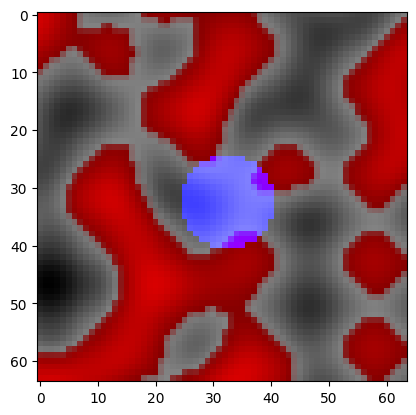

In [10]:
import matplotlib.pyplot as plt
state = Topo(0, 256, 0.52, 15, 0.5)
plt.imshow(state.render(64))

In [6]:

import cv2
import imageio
def upscale(image: np.ndarray):
  return cv2.resize(
    (image * 255).astype(np.uint8),
    (512, 512),
    interpolation=cv2.INTER_NEAREST
  )
frames = [upscale(images[i]) for i in range(0, len(images), 4)]
imageio.mimsave('vis.mp4', frames, fps=20)

In [40]:
import mujoco.viewer
import numpy as np

with MuJoCoTopo(Topo.random()) as sim:
  with mujoco.viewer.launch_passive(sim.model, sim.data) as viewer:
    viewer.cam.lookat[:] = [0, 0, 10]  # Point the camera looks at (x, y, z)
    viewer.cam.distance = 50  # Distance from lookat point
    viewer.cam.azimuth = 0  # Horizontal rotation (0-360 degrees)
    viewer.cam.elevation = -90  # Vertical angle (-90 to 90 degrees)
    t = 0
    
    while viewer.is_running():
      # Move in a circle
      if t % 300 == 0:
        sim.state.act((np.random.rand(2) * 2 - 1) * 4)
      
      sim.step()
      t += 1
      
      time.sleep(0.01)
      viewer.sync()

Created experiment\terrain.obj, experiment\terrain.mtl, and experiment\terrain.png
Vertices: 65536
Faces: 129032
Texture size: 64x64
act!!!!
act!!!!
act!!!!


Created experiment\terrain.obj, experiment\terrain.mtl, and experiment\terrain.png
Vertices: 147456
Faces: 291848
Texture size: 96x96


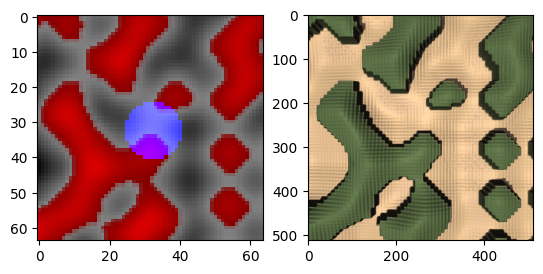

In [21]:
from typing import List
import matplotlib.pyplot as plt

def render_mujoco_rollout(initial_state: Topo, actions: List[np.ndarray], steps_between_actions: int = 10):
  state = initial_state.copy()

  images = []
  with MuJoCoTopo(state, topo_camera_height=85, render_distance=48, camera_size=512) as sim:
    images.append(sim.render(locked_angle=True))
    for action in actions:
      state.act(action)
      for _ in range(steps_between_actions):
        sim.step()
        images.append(sim.render(locked_angle=True))
  return images

state = Topo(0, 256, 0.52, 15, 0.5)
state.act(np.array([4, 4]))
mujoco_images = render_mujoco_rollout(state, [])

fig, axes = plt.subplots(1, 2)
axes[0].imshow(state.render(64))
axes[1].imshow(mujoco_images[0])